In [1]:
import numpy as np
import cv2
import os
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, jaccard_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

DATA_FOLDER = "./KTH_TIPS"
TEST_IMAGE = "test_bread.png"

print("Проверка существования папок:")
print(f"Папка KTH_TIPS существует: {os.path.exists(DATA_FOLDER)}")
print(f"Тестовое изображение существует: {os.path.exists(TEST_IMAGE)}")

if os.path.exists(DATA_FOLDER):
    print("\nПапки в KTH-TIPS:")
    for folder in os.listdir(DATA_FOLDER):
        folder_path = os.path.join(DATA_FOLDER, folder)
        if os.path.isdir(folder_path):
            files = os.listdir(folder_path)
            png_files = [f for f in files if f.lower().endswith('.png')]
            print(f"  {folder}: {len(png_files)} изображений")
else:
    print(f"ВНИМАНИЕ: Папка {DATA_FOLDER} не найдена!")
    print("Создайте папку KTH_TIPS и добавьте в неё текстуры")
    
if not os.path.exists(TEST_IMAGE):
    print(f"\nВНИМАНИЕ: Тестовое изображение {TEST_IMAGE} не найдено!")
    print("Добавьте файл test_bread.png в текущую директорию")


Проверка существования папок:
Папка KTH_TIPS существует: True
Тестовое изображение существует: True

Папки в KTH-TIPS:
  aluminium_foil: 81 изображений
  brown_bread: 81 изображений
  corduroy: 81 изображений
  cotton: 81 изображений
  cracker: 81 изображений
  linen: 81 изображений
  orange_peel: 81 изображений
  sandpaper: 81 изображений
  sponge: 81 изображений
  styrofoam: 81 изображений


In [2]:
def extract_histogram_features(gray_image):
    if gray_image is None or gray_image.size == 0:
        return np.zeros(10)
    
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
    hist = hist.flatten() / hist.sum()
    
    values = np.arange(256)
    mean = np.sum(hist * values)
    variance = np.sum(hist * (values - mean)**2)
    std = np.sqrt(variance)
    
    skewness = 0
    kurtosis = -3
    if std > 0:
        skewness = np.sum(hist * ((values - mean) / std)**3)
        kurtosis = np.sum(hist * ((values - mean) / std)**4) - 3
    
    non_zero = hist[hist > 0]
    entropy = -np.sum(non_zero * np.log2(non_zero)) if len(non_zero) > 0 else 0
    
    cumulative = np.cumsum(hist)
    q1 = np.argmax(cumulative >= 0.25) if np.any(cumulative >= 0.25) else 0
    median = np.argmax(cumulative >= 0.5) if np.any(cumulative >= 0.5) else 0
    q3 = np.argmax(cumulative >= 0.75) if np.any(cumulative >= 0.75) else 0
    
    non_zero_bins = np.where(hist > 0)[0]
    min_val = non_zero_bins[0] if len(non_zero_bins) > 0 else 0
    max_val = non_zero_bins[-1] if len(non_zero_bins) > 0 else 255
    
    return np.array([mean, std, skewness, kurtosis, entropy, q1, median, q3, min_val, max_val])

In [3]:
def extract_laws_features(image):
    if image is None or image.size == 0:
        return np.zeros(25)
    
    L5 = np.array([1, 4, 6, 4, 1])
    E5 = np.array([-1, -2, 0, 2, 1])
    S5 = np.array([-1, 0, 2, 0, -1])
    W5 = np.array([-1, 2, 0, -2, 1])
    R5 = np.array([1, -4, 6, -4, 1])
    
    masks = [L5, E5, S5, W5, R5]
    features = []
    
    for i, mask1 in enumerate(masks):
        for j, mask2 in enumerate(masks):
            kernel = np.outer(mask1, mask2)
            filtered = cv2.filter2D(image.astype(np.float32), -1, kernel)
            energy = np.mean(filtered ** 2)
            features.append(energy)
    
    features = np.array(features)
    if np.sum(features) > 0:
        features = features / np.sum(features)
    
    return features

In [4]:
def extract_glcm_features(image):
    if image is None or image.size == 0:
        return np.zeros(5)
    
    image_quantized = (image // 8).astype(np.uint8)
    
    try:
        glcm = graycomatrix(image_quantized, 
                           distances=[1], 
                           angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                           levels=32, 
                           symmetric=True, 
                           normed=True)
        
        features = []
        props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
        
        for prop in props:
            feature_val = graycoprops(glcm, prop)
            features.append(np.mean(feature_val))
        
        return np.array(features)
    except Exception as e:
        print(f"Ошибка при вычислении GLCM: {e}")
        return np.zeros(5)

In [5]:
def load_kth_tips_dataset(folder_path):
    X_hist, X_laws, X_glcm, y = [], [], [], []
    
    if not os.path.exists(folder_path):
        print(f"Ошибка: папка {folder_path} не найдена!")
        return np.array(X_hist), np.array(X_laws), np.array(X_glcm), np.array(y)
    
    class_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    
    if not class_folders:
        print(f"В папке {folder_path} нет подпапок с классами!")
        return np.array(X_hist), np.array(X_laws), np.array(X_glcm), np.array(y)
    
    for class_name in class_folders:
        class_path = os.path.join(folder_path, class_name)
            
        print(f"Загрузка {class_name}...")
        
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith('.png')]
        
        for file in image_files[:50]:
            img_path = os.path.join(class_path, file)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if image is None:
                print(f"  Не удалось загрузить {file}")
                continue
                    
            image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
            
            X_hist.append(extract_histogram_features(image))
            X_laws.append(extract_laws_features(image))
            X_glcm.append(extract_glcm_features(image))
            y.append(class_name)
    
    return np.array(X_hist), np.array(X_laws), np.array(X_glcm), np.array(y)

print("\nЗагрузка датасета KTH-TIPS...")
X_hist, X_laws, X_glcm, y = load_kth_tips_dataset(DATA_FOLDER)

if len(y) > 0:
    print(f"\nЗагружено {len(y)} изображений")
    print(f"Гистограмма: {X_hist.shape}")
    print(f"Laws: {X_laws.shape}")
    print(f"GLCM: {X_glcm.shape}")
    print(f"Уникальные классы: {np.unique(y)}")
else:
    print("\nНе удалось загрузить данные! Проверьте структуру папок.")
    print("Ожидается: KTH_TIPS/class1/*.png, KTH_TIPS/class2/*.png, ...")
    
    print("Создаю демо-данные для тестирования...")
    np.random.seed(42)
    n_samples = 100
    n_classes = 5
    
    X_hist = np.random.randn(n_samples, 10)
    X_laws = np.random.randn(n_samples, 25)
    X_glcm = np.random.randn(n_samples, 5)
    y = np.array(['class_' + str(i % n_classes) for i in range(n_samples)])


Загрузка датасета KTH-TIPS...
Загрузка aluminium_foil...
Загрузка brown_bread...
Загрузка corduroy...
Загрузка cotton...
Загрузка cracker...
Загрузка linen...
Загрузка orange_peel...
Загрузка sandpaper...
Загрузка sponge...
Загрузка styrofoam...

Загружено 500 изображений
Гистограмма: (500, 10)
Laws: (500, 25)
GLCM: (500, 5)
Уникальные классы: ['aluminium_foil' 'brown_bread' 'corduroy' 'cotton' 'cracker' 'linen'
 'orange_peel' 'sandpaper' 'sponge' 'styrofoam']


In [6]:
def train_classifiers(X, y, feature_name):
    """Обучение классификаторов на различных признаках"""
    if len(np.unique(y)) < 2:
        print(f"  Ошибка: недостаточно классов ({len(np.unique(y))}) для обучения")
        return {}, None
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    classifiers = {
        'kNN': KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
        'SVM': SVC(kernel='rbf', C=10, gamma='scale', random_state=42),
        'Decision Tree': DecisionTreeClassifier(max_depth=15, random_state=42)
    }
    
    results = {}
    
    for name, clf in classifiers.items():
        try:
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_test_scaled)
            accuracy = accuracy_score(y_test, y_pred)
            
            results[name] = {
                'model': clf,
                'scaler': scaler,
                'accuracy': accuracy,
                'predictions': y_pred,
                'true_labels': y_test,
                'label_encoder': le
            }
            
            print(f"  {name}: Точность = {accuracy:.4f}")
        except Exception as e:
            print(f"  Ошибка при обучении {name}: {e}")
    
    return results, le

print("Обучение на гистограммных признаках:")
results_hist, le_hist = train_classifiers(X_hist, y, "Histogram")

print("\nОбучение на Laws признаках:")
results_laws, le_laws = train_classifiers(X_laws, y, "Laws")

print("\nОбучение на GLCM признаках:")
results_glcm, le_glcm = train_classifiers(X_glcm, y, "GLCM")

Обучение на гистограммных признаках:
  kNN: Точность = 0.8720
  SVM: Точность = 0.8800
  Decision Tree: Точность = 0.7280

Обучение на Laws признаках:
  kNN: Точность = 0.8000
  SVM: Точность = 0.7120
  Decision Tree: Точность = 0.7440

Обучение на GLCM признаках:
  kNN: Точность = 0.6880
  SVM: Точность = 0.6400
  Decision Tree: Точность = 0.5920



Сравнение точности классификации:
Тип признаков        Модель  Точность
    Histogram           SVM     0.880
    Histogram           kNN     0.872
         Laws           kNN     0.800
         Laws Decision Tree     0.744
    Histogram Decision Tree     0.728
         Laws           SVM     0.712
         GLCM           kNN     0.688
         GLCM           SVM     0.640
         GLCM Decision Tree     0.592


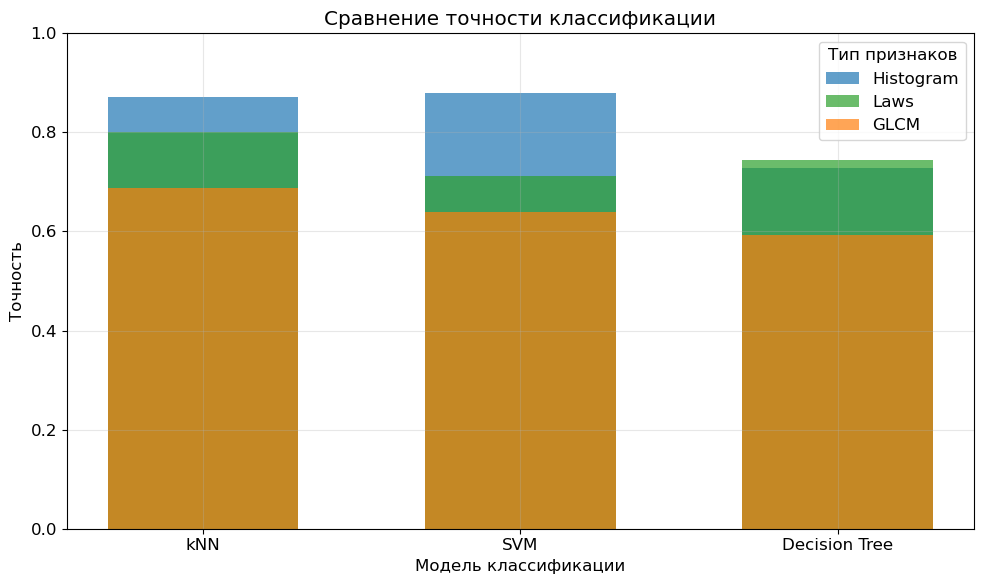


Лучшая модель: Histogram + SVM
Точность: 0.8800


In [7]:
comparison_data = []

for feature_name, results in [('Histogram', results_hist), ('Laws', results_laws), ('GLCM', results_glcm)]:
    for model_name, result in results.items():
        comparison_data.append({
            'Тип признаков': feature_name,
            'Модель': model_name,
            'Точность': result['accuracy']
        })

if comparison_data:
    df_comparison = pd.DataFrame(comparison_data)
    print("\nСравнение точности классификации:")
    print(df_comparison.sort_values('Точность', ascending=False).to_string(index=False))

    plt.figure(figsize=(10, 6))
    colors = {'Histogram': '#1f77b4', 'Laws': '#2ca02c', 'GLCM': '#ff7f0e'}

    for feature_type, color in colors.items():
        subset = df_comparison[df_comparison['Тип признаков'] == feature_type]
        if len(subset) > 0:
            plt.bar(subset['Модель'], subset['Точность'], color=color, 
                    alpha=0.7, label=feature_type, width=0.6)

    plt.xlabel('Модель классификации')
    plt.ylabel('Точность')
    plt.title('Сравнение точности классификации')
    plt.legend(title='Тип признаков')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()
    
    best_row = df_comparison.loc[df_comparison['Точность'].idxmax()]
    best_feature = best_row['Тип признаков']
    best_model = best_row['Модель']
    
    print(f"\nЛучшая модель: {best_feature} + {best_model}")
    print(f"Точность: {best_row['Точность']:.4f}")
    
    if best_feature == 'Histogram':
        best_result = results_hist[best_model]
    elif best_feature == 'Laws':
        best_result = results_laws[best_model]
    else:
        best_result = results_glcm[best_model]
else:
    print("Нет данных для сравнения!")
    best_feature = None
    best_model = None

In [8]:
def segment_image(image_path, model_info, feature_type, patch_size=32, step=16):
    if not os.path.exists(image_path):
        print(f"Файл {image_path} не найден!")
        return None
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Не удалось загрузить изображение {image_path}")
        return None
    
    h, w = image.shape
    seg_map = np.zeros((h, w), dtype=np.uint8)
    
    model = model_info['model']
    scaler = model_info['scaler']
    
    for y in range(0, h - patch_size + 1, step):
        for x in range(0, w - patch_size + 1, step):
            patch = image[y:y+patch_size, x:x+patch_size]
            
            if feature_type == 'Histogram':
                features = extract_histogram_features(patch)
            elif feature_type == 'Laws':
                features = extract_laws_features(patch)
            else:  # GLCM
                features = extract_glcm_features(patch)
            
            features_scaled = scaler.transform(features.reshape(1, -1))
            pred_class = model.predict(features_scaled)[0]
            seg_map[y:y+patch_size, x:x+patch_size] = pred_class
    
    return seg_map

Обработка тестового изображения: test_bread.png


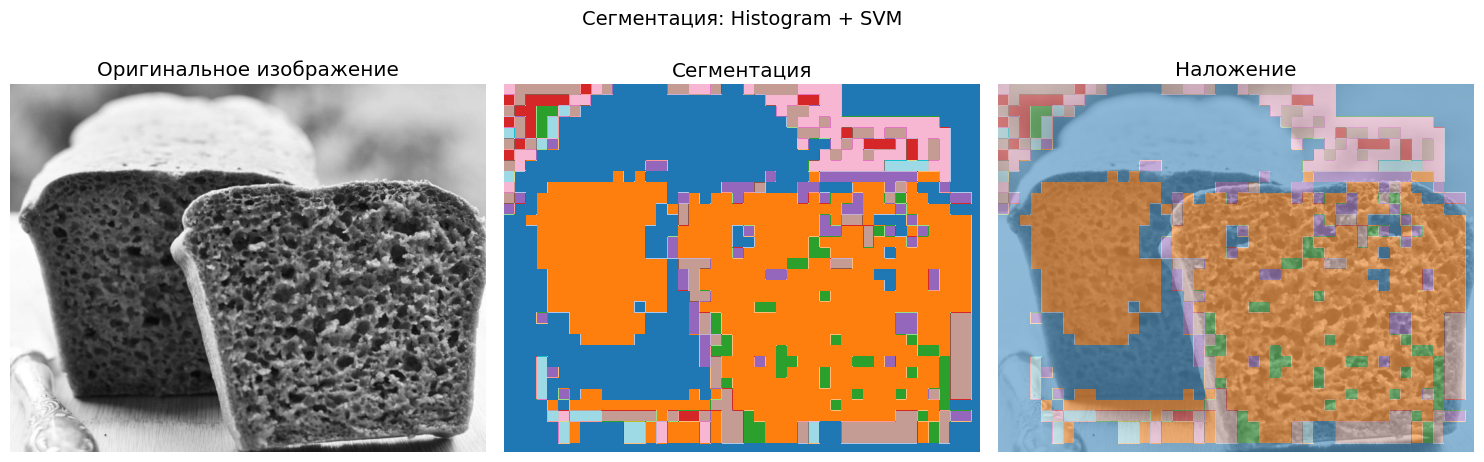

In [9]:
if os.path.exists(TEST_IMAGE) and best_feature is not None:
    print(f"Обработка тестового изображения: {TEST_IMAGE}")
    
    original_img = cv2.imread(TEST_IMAGE, cv2.IMREAD_GRAYSCALE)
    if original_img is not None:
        segmentation = segment_image(TEST_IMAGE, best_result, best_feature)
        
        if segmentation is not None:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(original_img, cmap='gray')
            axes[0].set_title('Оригинальное изображение')
            axes[0].axis('off')
            
            axes[1].imshow(segmentation, cmap='tab20')
            axes[1].set_title('Сегментация')
            axes[1].axis('off')
            
            axes[2].imshow(original_img, cmap='gray', alpha=0.7)
            axes[2].imshow(segmentation, cmap='tab20', alpha=0.5)
            axes[2].set_title('Наложение')
            axes[2].axis('off')
            
            plt.suptitle(f'Сегментация: {best_feature} + {best_model}', fontsize=14)
            plt.tight_layout()
            plt.show()
        else:
            print("Не удалось выполнить сегментацию")
    else:
        print(f"Не удалось загрузить изображение {TEST_IMAGE}")
else:
    print(f"Тестовое изображение {TEST_IMAGE} не найдено или модель не обучена.")

In [10]:
def manual_segment(image):
    if image is None:
        return None
    
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        image_gray = image
    
    _, mask = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(mask)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(final_mask, [largest_contour], 0, 1, -1)
    
    return final_mask

def keep_top_colors(mask, n_colors=4):
    if mask is None or mask.size == 0:
        return mask
    
    unique, counts = np.unique(mask, return_counts=True)
    
    if len(unique) <= n_colors:
        return mask
    
    sorted_indices = np.argsort(-counts)
    top_colors = unique[sorted_indices[:n_colors]]
    
    print(f"Топ-{n_colors} самых частых цветов: {top_colors}")
    print(f"Их частоты: {counts[sorted_indices[:n_colors]]}")
    
    result = np.zeros_like(mask)
    for new_value, old_value in enumerate(top_colors):
        result[mask == old_value] = new_value
    
    print(f"Перенумеровано: {top_colors} -> {list(range(len(top_colors)))}")
    
    return result

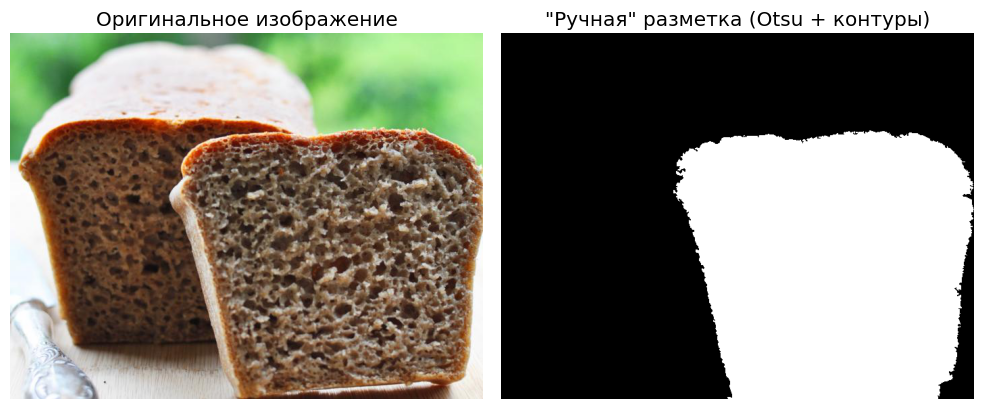

Ручная разметка сохранена в manual_mask_result.png


In [11]:
if os.path.exists(TEST_IMAGE):
    image = cv2.imread(TEST_IMAGE)
    if image is not None:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        manual_mask = manual_segment(image_rgb)
        
        if manual_mask is not None:
            fig, (ax_orig, ax_segment) = plt.subplots(1, 2, figsize=(10, 5))

            ax_orig.imshow(image_rgb)
            ax_orig.set_title('Оригинальное изображение')
            ax_orig.axis('off')

            ax_segment.imshow(manual_mask, cmap='gray')
            ax_segment.set_title('"Ручная" разметка (Otsu + контуры)')
            ax_segment.axis('off')

            plt.tight_layout()
            plt.show()
            
            cv2.imwrite("manual_mask_result.png", manual_mask * 255)
            print("Ручная разметка сохранена в manual_mask_result.png")
        else:
            print("Не удалось создать ручную разметку")
    else:
        print(f"Не удалось загрузить изображение {TEST_IMAGE}")
else:
    print(f"Тестовое изображение {TEST_IMAGE} не найдено")


Метрики качества сегментации:
  Точность (Accuracy): 0.7533
  IoU (Jaccard): 0.5262


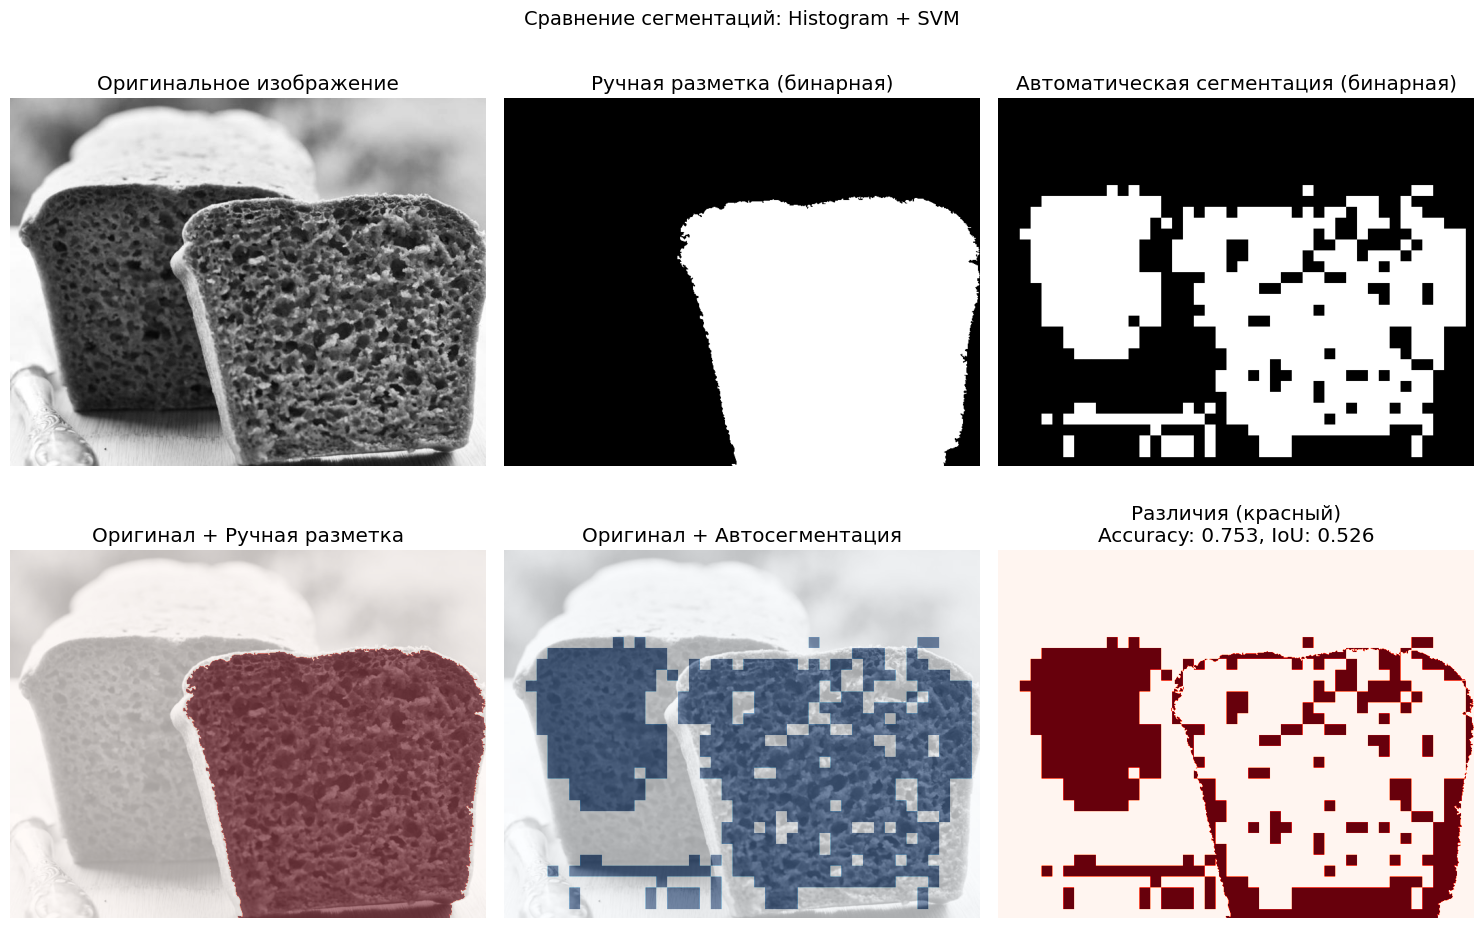

In [12]:
def compare_segmentations(manual_mask, auto_segmentation):
    if manual_mask is None or auto_segmentation is None:
        print("Ошибка: одна из сегментаций отсутствует")
        return 0, 0, None, None
    
    h, w = auto_segmentation.shape
    
    if len(manual_mask.shape) == 3:
        manual_gray = cv2.cvtColor(manual_mask, cv2.COLOR_BGR2GRAY)
    else:
        manual_gray = manual_mask
    
    manual_resized = cv2.resize(manual_gray, (w, h), interpolation=cv2.INTER_NEAREST)
    
    manual_binary = (manual_resized > 0).astype(np.uint8)
    
    unique, counts = np.unique(auto_segmentation, return_counts=True)
    if len(unique) > 1:
        background = unique[np.argmax(counts)]
        auto_binary = (auto_segmentation != background).astype(np.uint8)
    else:
        auto_binary = (auto_segmentation > 0).astype(np.uint8)
    
    agreement_direct = accuracy_score(manual_binary.flatten(), auto_binary.flatten())
    agreement_inverted = accuracy_score(manual_binary.flatten(), 1 - auto_binary.flatten())
    
    if agreement_inverted > agreement_direct:
        auto_binary = 1 - auto_binary
    
    accuracy = accuracy_score(manual_binary.flatten(), auto_binary.flatten())
    
    intersection = np.logical_and(manual_binary, auto_binary).sum()
    union = np.logical_or(manual_binary, auto_binary).sum()
    iou = intersection / union if union > 0 else 0
    
    return accuracy, iou, manual_binary, auto_binary

# Сравнение сегментаций
if os.path.exists(TEST_IMAGE) and best_feature is not None and 'manual_mask' in locals():
    segmentation = segment_image(TEST_IMAGE, best_result, best_feature)
    
    if segmentation is not None and manual_mask is not None:
        accuracy, iou, manual_binary, seg_binary = compare_segmentations(
            manual_mask, segmentation
        )
        
        print(f"\nМетрики качества сегментации:")
        print(f"  Точность (Accuracy): {accuracy:.4f}")
        print(f"  IoU (Jaccard): {iou:.4f}")
        
        original_img = cv2.imread(TEST_IMAGE, cv2.IMREAD_GRAYSCALE)
        
        if original_img is not None:
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            
            axes[0, 0].imshow(original_img, cmap='gray')
            axes[0, 0].set_title('Оригинальное изображение')
            axes[0, 0].axis('off')
            
            axes[0, 1].imshow(manual_binary, cmap='gray')
            axes[0, 1].set_title('Ручная разметка (бинарная)')
            axes[0, 1].axis('off')
            
            axes[0, 2].imshow(seg_binary, cmap='gray')
            axes[0, 2].set_title('Автоматическая сегментация (бинарная)')
            axes[0, 2].axis('off')
            
            axes[1, 0].imshow(original_img, cmap='gray', alpha=0.7)
            axes[1, 0].imshow(manual_binary, cmap='Reds', alpha=0.5)
            axes[1, 0].set_title('Оригинал + Ручная разметка')
            axes[1, 0].axis('off')
            
            axes[1, 1].imshow(original_img, cmap='gray', alpha=0.7)
            axes[1, 1].imshow(seg_binary, cmap='Blues', alpha=0.5)
            axes[1, 1].set_title('Оригинал + Автосегментация')
            axes[1, 1].axis('off')
            
            diff = manual_binary != seg_binary
            axes[1, 2].imshow(diff, cmap='Reds')
            axes[1, 2].set_title(f'Различия (красный)\nAccuracy: {accuracy:.3f}, IoU: {iou:.3f}')
            axes[1, 2].axis('off')
            
            plt.suptitle(f'Сравнение сегментаций: {best_feature} + {best_model}', fontsize=14)
            plt.tight_layout()
            plt.show()
        else:
            print("Не удалось загрузить оригинальное изображение для визуализации")
    else:
        print("Ошибка: не удалось получить сегментацию или ручную разметку")